# Maria's notebook

Analysis of miscarriage and depression using Twitter data from relevant dates to the topic. I will explore:
1. Most prolific authors
2. Tweets/day
3. Correlation
4. Sentiment analysis related to popularity

### Import the neccesary libraries and modules to the notebook

In [1]:
#Data operations (visualize and manipulate)

import json
import missingno as msno
import csv
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas.core.apply import frame_apply
from pandas import Series

In [2]:
#Packages for text cleaning 

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
#Time and dates management

from datetime import datetime
import time

In [4]:
#Sentiment analysis

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
#nltk.downloader.download('vader_lexicon')
from textblob import TextBlob

In [5]:
#Topic extraction

import gensim
from gensim import corpora, models
from gensim.matutils import jaccard
from gensim.models import LdaModel
from gensim.models import CoherenceModel

In [6]:
#Data visualization

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### Obtaining the data

The data that will be used is stored in the DataCollection folder. 


In [7]:
path_tweets = 'dataCollection/tweets_miscarriage_all_wo_reply.json'
print(path_tweets)

dataCollection/tweets_miscarriage_all_wo_reply.json


In [8]:
#A list is created with all the collected tweets & metadata (author, date, time, metrics, etc).

tweets = list()
n = 0
#To make sure all tweets are read
max_row = 10000000  

#Open(.., 'r') only read mode. t=tweets & l=loads
with open(path_tweets, 'r') as t: 
    for l in t: 
        tweets.append(json.loads(l))    #Creates a diccionary

#Creation of a dataframe with all the compiled information
df = pd.DataFrame(tweets)

In [9]:
#Visualize the dataframe and its columns
print(f'This is the original columns without any transformation: {df.columns}\n')

#Take a sample from the population
#df = df.sample(n = 10000, axis=0)
len_initial = len(df)

print(f"The dataframe has {len(df)} entries\n")
print(f"The dataframe has {len(df.axes[1])} columns or observations\n")


This is the original columns without any transformation: Index(['_id', 'id', 'author', 'author_id', 'conversation_id', 'created_at',
       'edit_history_tweet_ids', 'lang', 'public_metrics', 'text',
       'referenced_tweets', 'attachments', 'geo', 'withheld'],
      dtype='object')

The dataframe has 97965 entries

The dataframe has 14 columns or observations



In [10]:
#Createa a function to normalize the json data and transform into a dictionary format 
def normalized_data(df, col):
    df2 = pd.json_normalize(df[col])
    df2.columns = ['{}.{}'.format(col, x) for x in df2.columns]
    df = df.join(df2)
    del df[col]
    return df

In [11]:
#Apply transformations on the fields of our interest
df = normalized_data(df, 'author')
df = normalized_data(df, 'public_metrics')
df = normalized_data(df, 'geo')

In [12]:
#Print again to watch the transformation on the columns
print(f"These are the new columns: {df.columns}\n")

These are the new columns: Index(['_id', 'id', 'author_id', 'conversation_id', 'created_at',
       'edit_history_tweet_ids', 'lang', 'text', 'referenced_tweets',
       'attachments', 'withheld', 'author.id', 'author.username',
       'author.created_at', 'author.name', 'author.location',
       'author.withheld.country_codes', 'author.withheld.scope',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'geo.place_id', 'geo.country', 'geo.full_name', 'geo.id',
       'geo.coordinates.type', 'geo.coordinates.coordinates'],
      dtype='object')



## Languaje filtering
After columns normalization and transformation we filter the tweets in english for the sentiment analysis. We also perform additional operations, but in this stance we wont obtain wether tweets are replies because the replies have not been obtained.

This function won't be necessary since the data collection did not include the replies:


def is_reply(df):
   
           df['is_reply'] = df['in_reply_to_user_id'].apply(lambda x: False if np.isnan(float(x)) else True)
            return df

In [13]:
#Filtering the tweets that are only in english
def filter_English_tweets(df):
    df = df[df['lang'] == 'en']
    return df

In [14]:
#Apply the function for transformations
df = filter_English_tweets(df)
len_after = len(df)

In [15]:
print(f"Before filtering the tweets we had 97965 entries, while now that we excluded those not in english we have {len(df)} entries in the dataframe")

Before filtering the tweets we had 97965 entries, while now that we excluded those not in english we have 92296 entries in the dataframe


{'initial': 97965, 'after': 92296}


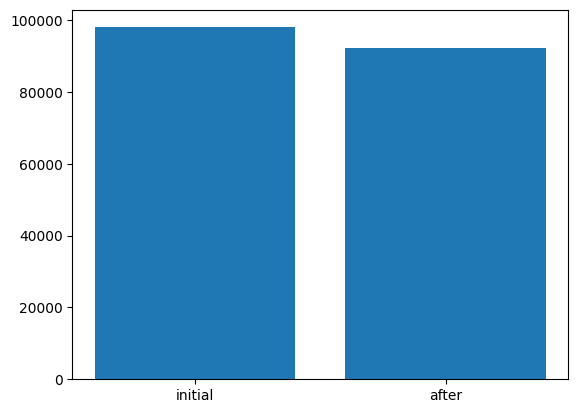

In [16]:
len_data = {'initial':len_initial, 'after':len_after}
print(len_data)

plt.bar(*zip(*len_data.items()))
plt.show()

<AxesSubplot: >

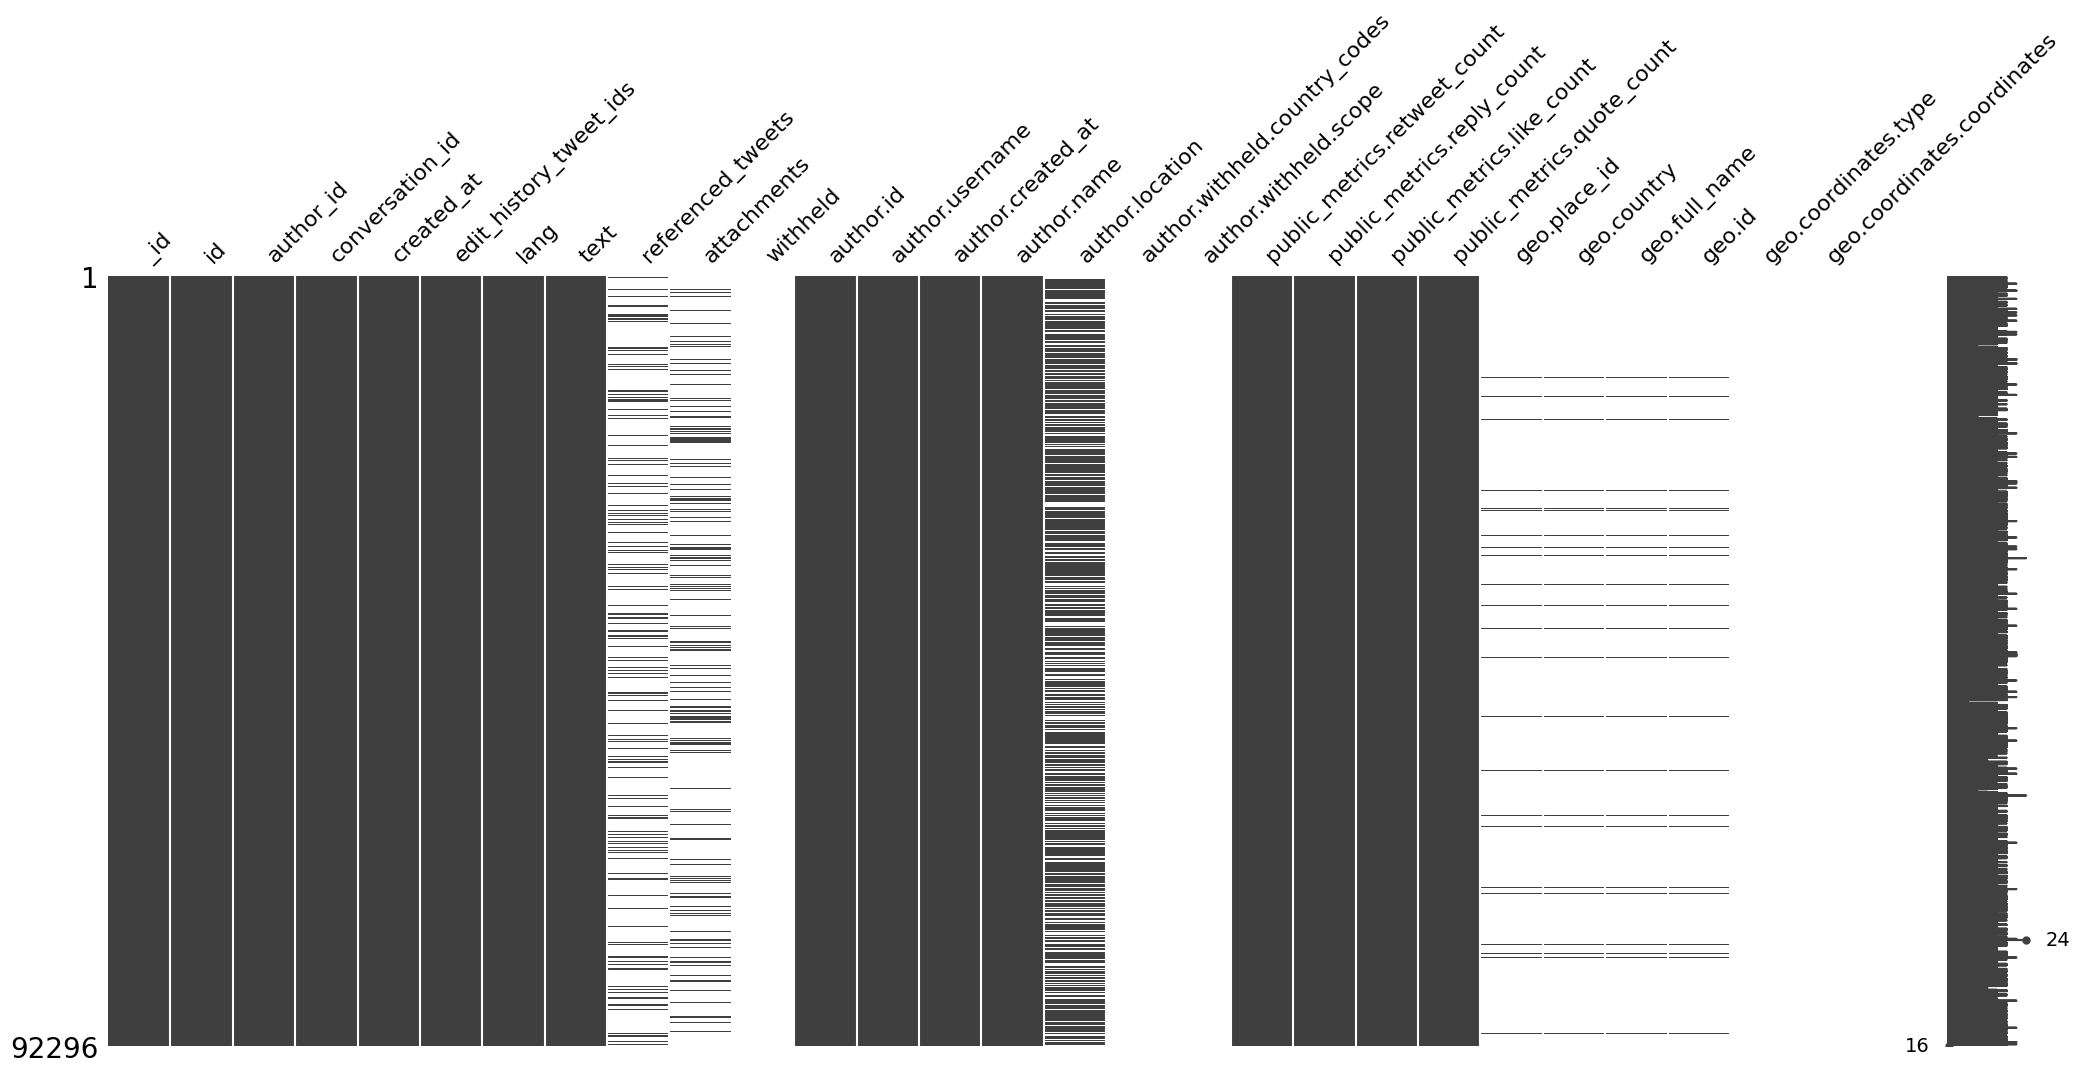

In [17]:
#This allows us to see the lenght (bottom left corner) as well as the density of information in each column 
msno.matrix(df)

## Text cleaning for the sentiment analysis

In [18]:
# Functions the mentioned text cleaning steps


# Removing extra spaces from all texts
def remove_extra_spaces(sentence):
    sentence = sentence.replace(r'\n',' ', regex=True) 
    sentence = sentence.replace(r'/\|/g',' ', regex=True) 
    return sentence


def lowercase_text(sentence):
    return sentence.lower()

def remove_usernames(sentence):
    sentence = re.sub(r'@\w+',' ', sentence)
    return sentence

def remove_hashtags(sentence):
    sentence = re.sub(r"#\w+",' ', sentence)
    return sentence

def remove_links(sentence):
    sentence = re.sub(r'\bhttps?://[^\s]*',' ', sentence)
    return sentence

def remove_numbers(sentence):
    sentence = re.sub(r'\d+',' ', sentence)
    return sentence

def remove_punctuation_and_spaces(sentence):
    sentence = re.sub(r'&', ' ', sentence) # Specific for &
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    sentence = ' '.join(sentence.split())
    return sentence

def remove_1letter_words(sentence):
    sentence = re.sub(r'\b\w{1}\b', ' ', sentence)
    return sentence

def tokenize(sentence):
    list_of_words = sentence.split(" ")
    return list_of_words

def remove_stopwords(list_of_words):
    # Getting English stopwords
    stop_words = set(stopwords.words('english'))

    filtered_words = []
    for word in list_of_words: 
        if word not in stop_words: 
            filtered_words.append(word) 

    return filtered_words

def lemmatize(list_of_words):
    # Getting English lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    lemma_words = []
    for w in list_of_words:
        word1 = wordnet_lemmatizer.lemmatize(w, pos = "n") # Names
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v") # Verbs
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a") # Adjectives
        lemma_words.append(word3)

    return lemma_words


     

# Function to apply all text tranformations
def text_cleaning(df):
    '''
    Given a pandas dataframe with tweets returns a list of clean tweet texts
    @input: pandas dataframe with tweets
    @output: list of clean tweets (same order as in df)
    '''
    lists_of_text = []

    for text in df['text']:
        sentence = str(text)

        # Text transformations
        sentence = lowercase_text(sentence) # All in lowercase
       # sentence = remove_extra_spaces(sentence)

        sentence = remove_links(sentence) # Remove links
        sentence = remove_hashtags(sentence) # Remove Hashtags
        sentence = remove_usernames(sentence) # Remove usernames
        sentence = remove_numbers(sentence) # Remove numbers
        sentence = remove_punctuation_and_spaces(sentence) # Remove punctuation signs and multiple spaces
        sentence = remove_1letter_words(sentence) # Remove words with len=1
        sentence = remove_punctuation_and_spaces(sentence)
        
        list_of_words = tokenize(sentence) # Tokenization
        list_of_words = remove_stopwords(list_of_words) # Remove stopwords
        list_of_words = lemmatize(list_of_words) # Lemmatization
        
        # Converting list of words to text again
        lists_of_text.append(' '.join(list_of_words))

    return lists_of_text

In [19]:
df['clean_text'] = text_cleaning(df)

# Authors
We want to see the authors that have contributed the most to the total amount of tweets during the selected days.

In [20]:
#We wish to obtain the authors with most contributions, we group them by name and order (ascending)

most_prolific = df.groupby('author.username').size().sort_values(ascending = False)
most_prolific

author.username
TomthunkitsMind    462
LifeNewsHQ         134
littlebytesnews    127
LifeNewsToo        127
Inspiredtvgh       119
                  ... 
NewsUSAofficial      1
NewsViews_           1
NewsVirginian        1
NewsWire_US          1
zzzi_ki              1
Length: 54013, dtype: int64

In [21]:
#We transform it into a data frame and reset the index to transform the name of the author (which is used as an index atm)

#To transform index into column we use .reset_index()

df_most_prolific = pd.DataFrame(most_prolific).reset_index()

In [22]:
df_most_prolific.columns = ["author_id", "count"]

In [23]:
df_most_prolific_15_most = df_most_prolific.head(15)
df_most_prolific_15_most

,author_id,count
0,TomthunkitsMind,462
1,LifeNewsHQ,134
2,littlebytesnews,127
3,LifeNewsToo,127
4,Inspiredtvgh,119
5,zhouzhoujyk,109
6,SafetyPinDaily,109
7,youkayoyo10059,107
8,g_kraig,102
9,br00t4c,97


Text(0, 0.5, 'Author username')

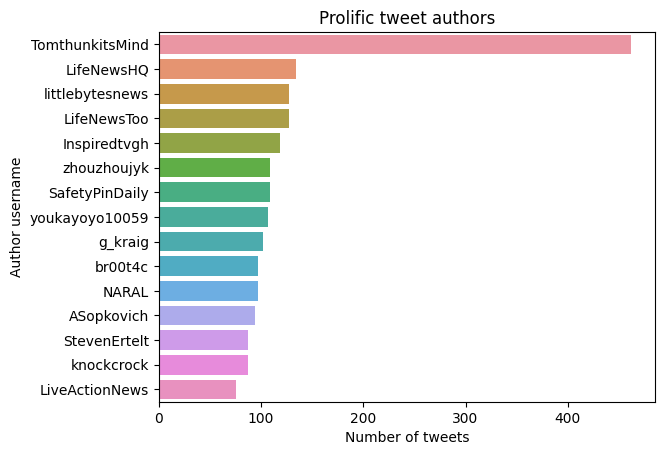

In [24]:
sns.barplot(
    x = df_most_prolific_15_most['count'],
     y = df_most_prolific_15_most['author_id'])
plt.title("Prolific tweet authors")
plt.xlabel("Number of tweets")
plt.ylabel("Author username")

### **Extracción cvs autores**

In [ ]:
df.head(5)

In [ ]:
# calculate metrics
df['metrics'] = df['public_metrics.like_count'] + df['public_metrics.quote_count'] + df['public_metrics.reply_count'] + df['public_metrics.retweet_count']

# group by author and count tweets
grouped = df.groupby('author.username')['id'].count()

# filter for authors with more than one tweet
grouped = grouped[grouped > 1]

# create new dataframe with metrics for selected authors
author_df = df.loc[df['author.username'].isin(grouped.index)][['author.username', 'metrics']]
author_df = author_df.groupby('author.username').agg({'metrics': ['count', 'sum']})
author_df.columns = ['frequency', 'total_metrics']
author_df = author_df.reset_index()

# sort by frequency
author_df = author_df.sort_values(by='frequency')

# save to csv
author_df.to_csv('/home/maria/git/Proyecto_misscarriage_git/MiscarriageTwitterAnalysis/authors_metrics2.csv', index=False)


In [ ]:
metrics = df['public_metrics.like_count'] + df['public_metrics.quote_count'] + df['public_metrics.reply_count'] + df['public_metrics.retweet_count']

In [ ]:
author_df = df[['author.username', 'public_metrics.like_count', 'public_metrics.quote_count', 'public_metrics.reply_count', 'public_metrics.retweet_count']]
author_df['metrics'] = author_df['public_metrics.like_count'] + author_df['public_metrics.quote_count'] + author_df['public_metrics.reply_count'] + author_df['public_metrics.retweet_count']
author_df.drop(columns = ['public_metrics.like_count', 'public_metrics.quote_count', 'public_metrics.reply_count', 'public_metrics.retweet_count'])


In [ ]:
print(df.info())

In [ ]:
cvs_export = author_df.groupby('author.username').agg({'metrics': ['count', 'sum']})
cvs_export.columns = ['frequency', 'total_metrics']
cvs_export = cvs_export.reset_index()
cvs_export.sort_values(by = 'frequency')
cvs_export.to_csv('/home/maria/git/Proyecto_misscarriage_git/authors_metrics.csv', index=False)


### Authors segregated by group

We performed a bot analysis (only on profiles that had > 1 tweet) that specifies the type of account as well (business, blue, government or general). 

## Dates
Explore as well the dates where the tweets were made, to compare between them. 
First we need to make sure our created_at column is a datetime object

In [25]:
# Transform into date time object ( datetime 64= yyyy-mm-dd-, 
#"ns" = nanosecond)
df['created_at'] = df['created_at'].astype('datetime64[ns]') 

In [26]:
df.loc[:,"created_at"] 

0       2021-10-14 23:58:58
1       2021-10-14 23:58:52
3       2021-10-14 23:58:47
4       2021-10-14 23:58:43
5       2021-10-14 23:58:21
                ...        
97959   2022-09-28 23:59:48
97961   2022-09-28 23:59:09
97962   2022-09-28 23:59:06
97963   2022-09-28 23:59:05
97964   2022-09-28 23:59:00
Name: created_at, Length: 92296, dtype: datetime64[ns]

In [27]:
#df['created_at'] = pd.to_datetime(df['created_at']).dt.normalize()
df['time'] = pd.to_datetime(df['created_at']).dt.time
df['date'] = df['created_at'].dt.date
df['date'] = df['date'].astype('datetime64[ns]')
df['year'] = df['created_at'].dt.year


df.columns

Index(['_id', 'id', 'author_id', 'conversation_id', 'created_at',
       'edit_history_tweet_ids', 'lang', 'text', 'referenced_tweets',
       'attachments', 'withheld', 'author.id', 'author.username',
       'author.created_at', 'author.name', 'author.location',
       'author.withheld.country_codes', 'author.withheld.scope',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'geo.place_id', 'geo.country', 'geo.full_name', 'geo.id',
       'geo.coordinates.type', 'geo.coordinates.coordinates', 'clean_text',
       'time', 'date', 'year'],
      dtype='object')

In [28]:
#Delete the dates that are not wanted
df = df[df['date'] != '2021-09-26']
df = df[df['date'] != '2021-10-13']
df = df[df['date'] != '2022-09-26']
df = df[df['date'] != '2022-10-13']

#### Create a column named event
We need to compare between the two different events from two years

In [29]:
def categorize_withyear(df):
    df['event'] = ''
    df.loc[(df['date'].dt.date >= pd.to_datetime('2021-09-27').date()) & (df['date'].dt.date <= pd.to_datetime('2021-09-29').date()), 'event'] = 'Abortion 21'
    df.loc[(df['date'].dt.date >= pd.to_datetime('2022-09-27').date()) & (df['date'].dt.date <= pd.to_datetime('2022-09-29').date()), 'event'] = 'Abortion 22'
    df.loc[(df['date'].dt.date >= pd.to_datetime('2021-10-14').date()) & (df['date'].dt.date <= pd.to_datetime('2021-10-16').date()), 'event'] = 'Miscarriage 21'
    df.loc[(df['date'].dt.date >= pd.to_datetime('2022-10-14').date()) & (df['date'].dt.date <= pd.to_datetime('2022-10-16').date()), 'event'] = 'Miscarriage 22'
    return df

df = categorize_withyear(df)

In [30]:
def categorize_noyear(df):
    df['event_noyear'] = ''
    df.loc[(df['date'].dt.date >= pd.to_datetime('2021-09-27').date()) & (df['date'].dt.date <= pd.to_datetime('2021-09-29').date()), 'event_noyear'] = 'Abortion'
    df.loc[(df['date'].dt.date >= pd.to_datetime('2022-09-27').date()) & (df['date'].dt.date <= pd.to_datetime('2022-09-29').date()), 'event_noyear'] = 'Abortion'
    df.loc[(df['date'].dt.date >= pd.to_datetime('2021-10-14').date()) & (df['date'].dt.date <= pd.to_datetime('2021-10-16').date()), 'event_noyear'] = 'Miscarriage'
    df.loc[(df['date'].dt.date >= pd.to_datetime('2022-10-14').date()) & (df['date'].dt.date <= pd.to_datetime('2022-10-16').date()), 'event_noyear'] = 'Miscarriage'
    return df

df = categorize_noyear(df)

In [31]:
#we group by date and create a new dataframe for data manipulation
df_dates = df.groupby(pd.Grouper(key='date'))['date'].count()

#Transform the dataset into a dataframe for manipulation
df_dates = pd.DataFrame(df_dates)

#Reset the index to rename the columns and plot the results
df_dates.columns = ['count']
df_dates = df_dates.reset_index()
df_dates.columns = ['date', 'count']
df_dates = df_dates.sort_values(by = 'date')

df_dates

,date,count
3,2021-09-27,5740
4,2021-09-28,6824
5,2021-09-29,6406
0,2021-10-14,4993
1,2021-10-15,6977
2,2021-10-16,3098
9,2022-09-27,12753
10,2022-09-28,11471
11,2022-09-29,11443
6,2022-10-14,8511


#### Analysis of tweets per day

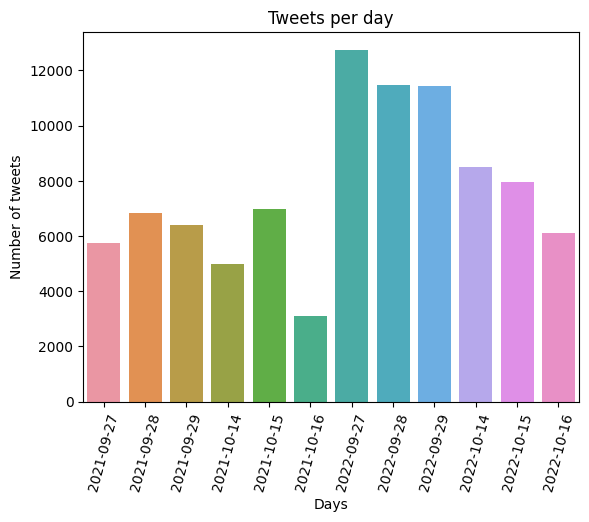

In [32]:
tweets_day = sns.barplot(
    x = df_dates['date'].dt.date.astype(str),
     y = df_dates['count'])
plt.title("Tweets per day")
plt.xlabel("Days")
plt.ylabel("Number of tweets")
plt.xticks(rotation=75)
plt.show()

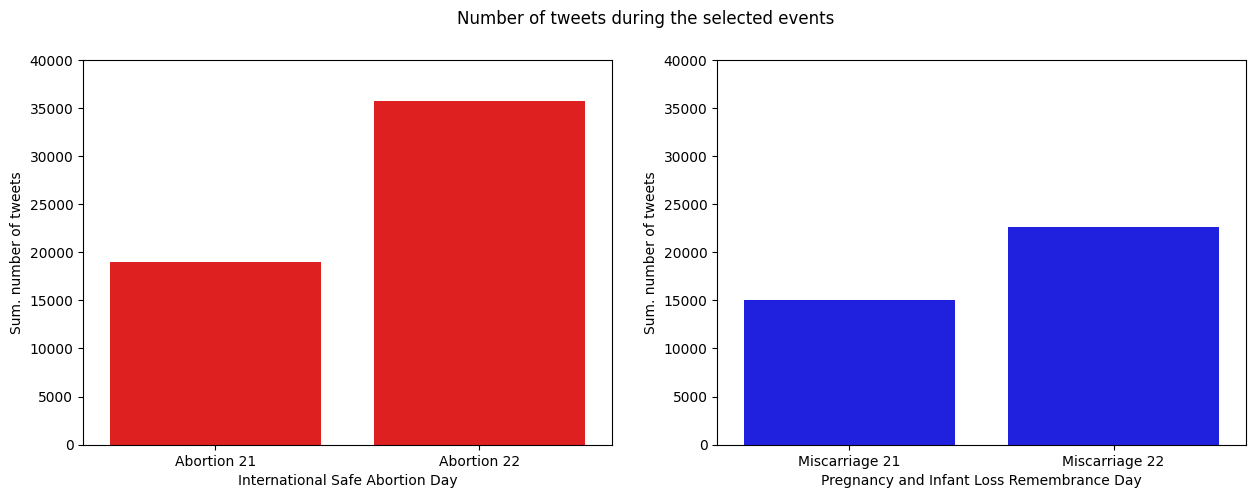

In [33]:
#Categorize by events to compare in graph
df_dates = categorize_withyear(df_dates)

#create subplots to show the two different events
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# create first bar plot for the International Safe Abortion Day 
#With isin() we select the events that match the argument
df_abortion = df_dates[df_dates['event'].isin(['Abortion 21', 'Abortion 22'])]
#groupby the two different years and get the sum count for the plot
df_abortion = df_abortion.groupby('event').agg({'count':'sum'}).reset_index()
#Plot
sns.barplot(x='event', y='count', data=df_abortion, color='red', ax=axs[0])
fig.suptitle('Number of tweets during the selected events')
axs[0].set_xlabel('International Safe Abortion Day')
axs[0].set_ylabel('Sum. number of tweets')
axs[0].set_ylim(0, 40000)

# create second bar plot
df_miscarriage = df_dates[df_dates['event'].isin(['Miscarriage 21', 'Miscarriage 22'])]
df_miscarriage = df_miscarriage.groupby('event').agg({'count':'sum'}).reset_index()
sns.barplot(x='event', y='count', data=df_miscarriage, color='blue', ax=axs[1])
axs[1].set_xlabel('Pregnancy and Infant Loss Remembrance Day')
axs[1].set_ylabel('Sum. number of tweets')
axs[1].set_ylim(0, 40000)

plt.show()

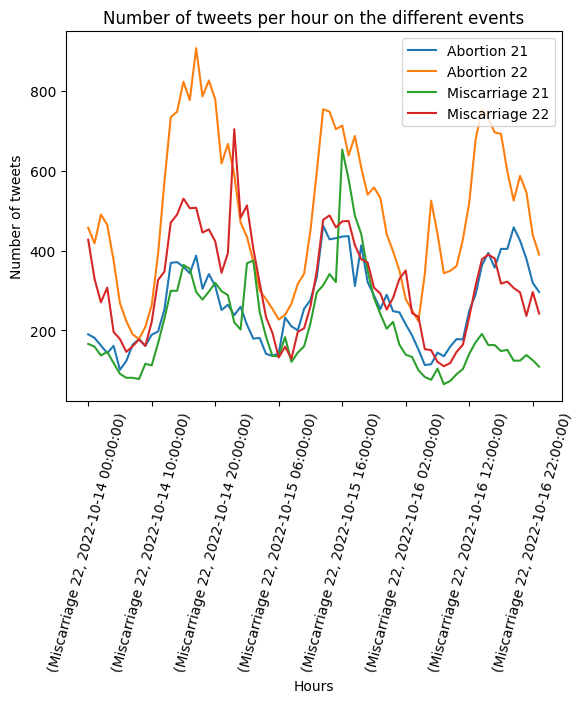

In [34]:
# Group the data by event and hour
grouped = df.groupby(['event', pd.Grouper(key='created_at', freq='H')])

# resample the data by hour
resampled = grouped['event'].count()

# plot the tweets per hour for each event
for event, data in resampled.groupby(level=0):
    data.plot(label=event)
plt.title('Number of tweets per hour on the different events')   
plt.xlabel("Hours")
plt.ylabel("Number of tweets")
plt.legend()
plt.xticks(rotation=75)
plt.show()

# Sentiment Analysis
### Interactions and emotions

To study wether the tweets with more interactions have a positive or negativ emotion we have to:
1. Group by cols
2. Choose a sample population with the most liked tweets
3. Perform sentiment analysis


In [35]:
#Analyze all tweets to get the most positive and the most negative ones
#Choose only the relevant columns for the study

df_allsentiment = df[['created_at', 'author.username', 'public_metrics.retweet_count', 'public_metrics.reply_count', 'public_metrics.like_count', 'clean_text', 'date', 'event', 'year', 'event_noyear']]
df_allsentiment.rename(columns = {'clean_text':'text'}, inplace = True)

def sentiment_analysis_polarity_NLTK(df):
    '''
    Given a dataframe with tweets, it adds 4 new columns to express sentiment polarity:
    negative score, positive score, neutral score and compound
    '''

    sia = SentimentIntensityAnalyzer()

    tweets = df_allsentiment['text']

    negative_values = []
    neutral_values = []
    positive_values = []
    compound_values = []

    for tweet in tweets:
        polarity_dict = sia.polarity_scores(tweet)
        
        negative_values.append(polarity_dict['neg'])
        neutral_values.append(polarity_dict['neu'])
        positive_values.append(polarity_dict['pos'])
        compound_values.append(polarity_dict['compound'])

    df['polarity_negative'] = negative_values
    df['polarity_positive'] = positive_values
    df['polarity_neutral'] = neutral_values
    df['polarity_compound'] = compound_values
    
    return df


df_allsentiment_transformed = sentiment_analysis_polarity_NLTK(df_allsentiment)

/tmp/ipykernel_134616/2091830090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsentiment.rename(columns = {'clean_text':'text'}, inplace = True)
/tmp/ipykernel_134616/2091830090.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarity_negative'] = negative_values
/tmp/ipykernel_134616/2091830090.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [36]:
#Function to obtain subjectivity
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Function for general polarity
def polarity(text):
    return TextBlob(text).sentiment.polarity
df_allsentiment_transformed['text'] = df_allsentiment_transformed['text'].astype(str)


df_allsentiment_transformed['subjectivity'] = df_allsentiment_transformed['text'].apply(subjectivity)
df_allsentiment_transformed['polarity'] = df_allsentiment_transformed['text'].apply(polarity)

/tmp/ipykernel_134616/1035513692.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsentiment_transformed['text'] = df_allsentiment_transformed['text'].astype(str)
/tmp/ipykernel_134616/1035513692.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsentiment_transformed['subjectivity'] = df_allsentiment_transformed['text'].apply(subjectivity)
/tmp/ipykernel_134616/1035513692.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

### Sentiment analysis ROBERTA
Source: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

In [ ]:
df['preprocessed_text'] = ''

for i, row in df.iterrows():
    df.at[i, 'preprocessed_text'] = preprocess(row['text'])
    
print(df)

for tweet in text:
    tweet = preprocess(tweet)

In [ ]:
df_allsentiment.dtype()

In [ ]:
import torch

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
        return " ".join(new_text)

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)

text = df_allsentiment['text']

df_allsentiment['preprocessed_text'] = ''

for i, row in df.iterrows():
    df_allsentiment.at[i, 'preprocessed_text'] = preprocess(row['text'])

input = df_allsentiment['preprocessed_text'].tolist()

batch_size = 50
for i in range(0, 1, batch_size):
    current_batch = input[i: i+batch_size]
    encoded_input = tokenizer(current_batch, return_tensors='pt', padding=True, truncation=True)
    output = model(**encoded_input)
    print(len(output[0]))
    scores = output[0][0].detach().numpy()
    print(scores)
    
    #for row in output:
   #     scores = output[0][0].detach().numpy()
    #    scores = softmax(scores)
   # print(output)
#encoded_input = tokenizer(input, return_tensors='pt', padding=True, truncation=True)
#output = model(**encoded_input)
#scores = output[0][0].detach().numpy()
#scores = softmax(scores)
# # TF
# model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)
# text = "Covid cases are increasing fast!"
# encoded_input = tokenizer(text, return_tensors='tf')
# output = model(encoded_input)
# scores = output[0][0].numpy()
# scores = softmax(scores)
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")


In [ ]:
df_allsentiment_transformed['text'].dtype

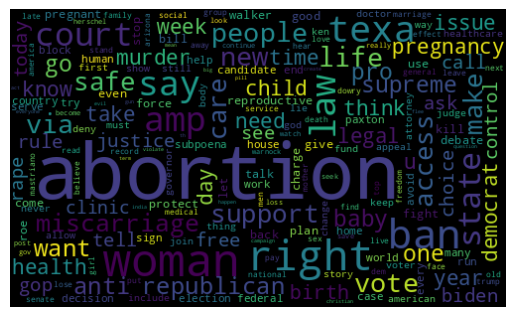

In [37]:
#Plot word cloud
#Important to add the collocations=False, otherwise we will get composite word results as 'Abortion ban', 'Abortion law', etc.
allWords = ' '.join( [text.strip() for text in df_allsentiment_transformed['text']] )
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, collocations = False).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [38]:
df_abortion21 = df_allsentiment_transformed[df_allsentiment_transformed['event'].isin(['Abortion 21'])]
df_abortion22 = df_allsentiment_transformed[df_allsentiment_transformed['event'].isin(['Abortion 22'])]
df_miscarriage21 = df_allsentiment_transformed[df_allsentiment_transformed['event'].isin(['Miscarriage 21'])]
df_miscarriage22 = df_allsentiment_transformed[df_allsentiment_transformed['event'].isin(['Miscarriage 22'])]


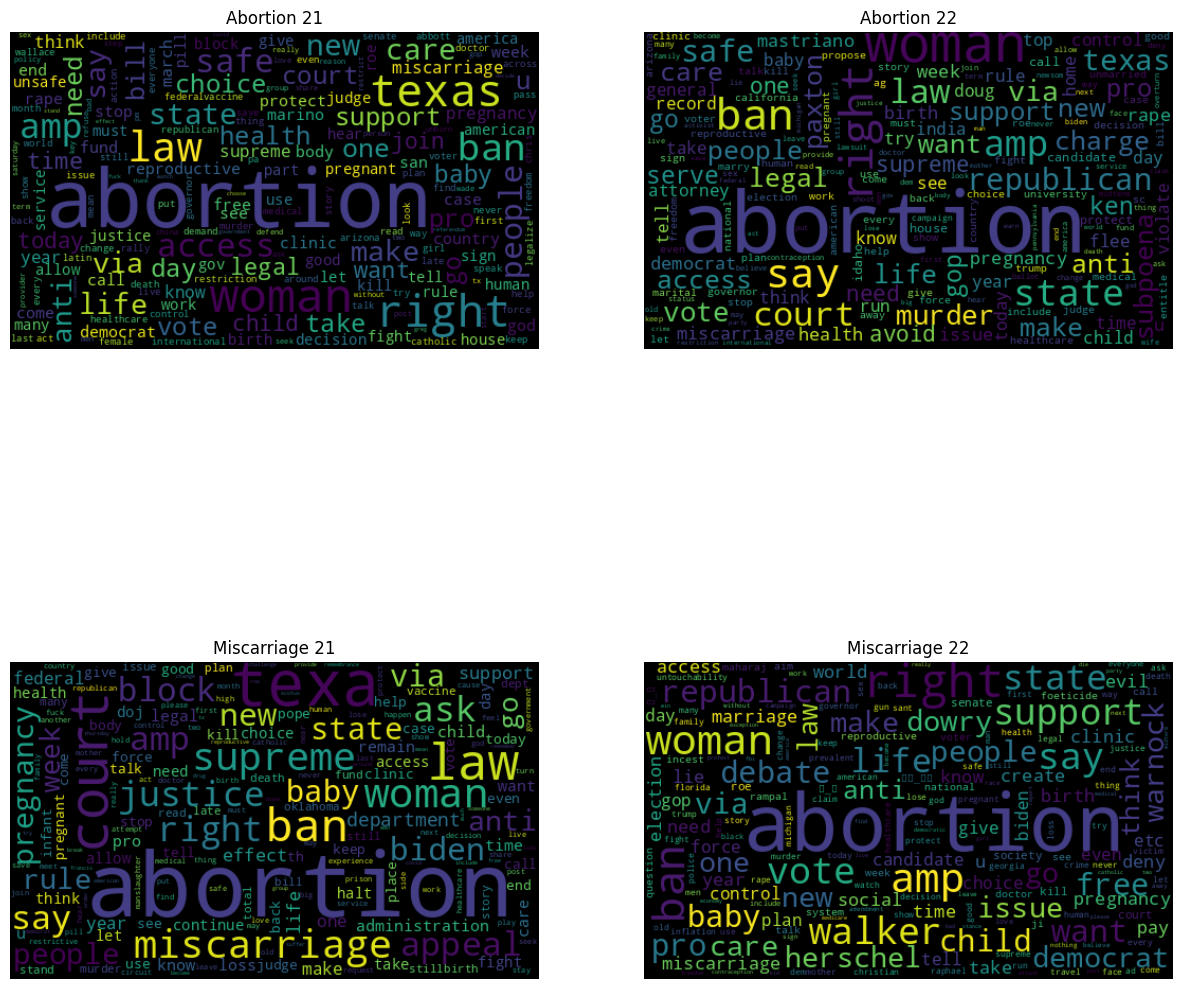

In [39]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15,15))

# Abortion 2021
allWords = ' '.join([text.strip() for text in df_abortion21['text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, collocations=False).generate(allWords)
axs[0,0].imshow(wordCloud, interpolation='bilinear')
axs[0,0].axis('off')
axs[0,0].set_title('Abortion 21')

# Abortion 2022
allWords = ' '.join([text.strip() for text in df_abortion22['text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, collocations=False).generate(allWords)
axs[0,1].imshow(wordCloud, interpolation='bilinear')
axs[0,1].axis('off')
axs[0,1].set_title('Abortion 22')

#Miscarriage 2021
allWords = ' '.join([text.strip() for text in df_miscarriage21['text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, collocations=False).generate(allWords)
axs[1,0].imshow(wordCloud, interpolation='bilinear')
axs[1,0].axis('off')
axs[1,0].set_title('Miscarriage 21')

#Miscarriage 2022
allWords = ' '.join([text.strip() for text in df_miscarriage22['text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, collocations=False).generate(allWords)
axs[1,1].imshow(wordCloud, interpolation='bilinear')
axs[1,1].axis('off')
axs[1,1].set_title('Miscarriage 22')

plt.show()

In [40]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df_allsentiment_transformed['analysed'] = df_allsentiment_transformed['polarity'].apply(getAnalysis)
df_allsentiment_transformed



/tmp/ipykernel_134616/1615155637.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsentiment_transformed['analysed'] = df_allsentiment_transformed['polarity'].apply(getAnalysis)


,created_at,author.username,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,text,date,event,year,event_noyear,polarity_negative,polarity_positive,polarity_neutral,polarity_compound,subjectivity,polarity,analysed
0,2021-10-14 23:58:58,yasplox,0,0,0,abortion remedy medieval catholic nun via,2021-10-14,Miscarriage 21,2021,Miscarriage,0.000,0.000,1.000,0.0000,0.050000,0.000000,Neutral
1,2021-10-14 23:58:52,RegisterCitizen,0,0,0,lawsuit challenge state law aim anti abortion ...,2021-10-14,Miscarriage 21,2021,Miscarriage,0.365,0.113,0.522,-0.4404,0.100000,-0.100000,Negative
3,2021-10-14 23:58:47,StamAdvocate,0,0,0,lawsuit challenge state law aim anti abortion ...,2021-10-14,Miscarriage 21,2021,Miscarriage,0.365,0.113,0.522,-0.4404,0.100000,-0.100000,Negative
4,2021-10-14 23:58:43,EricTerman,0,0,0,identity politics evil abortion evil open bord...,2021-10-14,Miscarriage 21,2021,Miscarriage,0.636,0.143,0.221,-0.9758,0.870635,-0.590476,Negative
5,2021-10-14 23:58:21,marcia4justice,0,0,0,furthermore imprison woman suffer miscarriage ...,2021-10-14,Miscarriage 21,2021,Miscarriage,0.320,0.133,0.547,-0.7003,0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97959,2022-09-28 23:59:48,GretchenJBerg,20,4,62,part coalition television showrunners creator ...,2022-09-28,Abortion 22,2022,Abortion,0.141,0.152,0.707,0.0516,0.000000,0.000000,Neutral
97961,2022-09-28 23:59:09,Aleja_487,3,0,4,day since nj legislator stall critical abortio...,2022-09-28,Abortion 22,2022,Abortion,0.269,0.311,0.420,0.2500,0.661111,0.066667,Positive
97962,2022-09-28 23:59:06,delanybomb,0,0,1,say say anything say woman center woman clinic...,2022-09-28,Abortion 22,2022,Abortion,0.133,0.000,0.867,-0.3182,0.166667,0.000000,Neutral
97963,2022-09-28 23:59:05,ROJNAME_english,0,0,0,mastriano woman face murder charge violate abo...,2022-09-28,Abortion 22,2022,Abortion,0.657,0.000,0.343,-0.9100,0.000000,0.000000,Neutral


In [41]:
df_allsentiment_transformed.loc[97961]["text"]

'day since nj legislator stall critical abortion access bill smh join u tomorrow tell loud clear ensure'

In [42]:
#Change column names
df_allsentiment_transformed.columns = ['created_at', 'author', 'rt', 'replies', 'likes', 'text','date', 'event', 'year', 'event_noyear', 'negative', 'positive', 'neutral', 'compound', 'subjectivity', 'polarity', 'analysed']

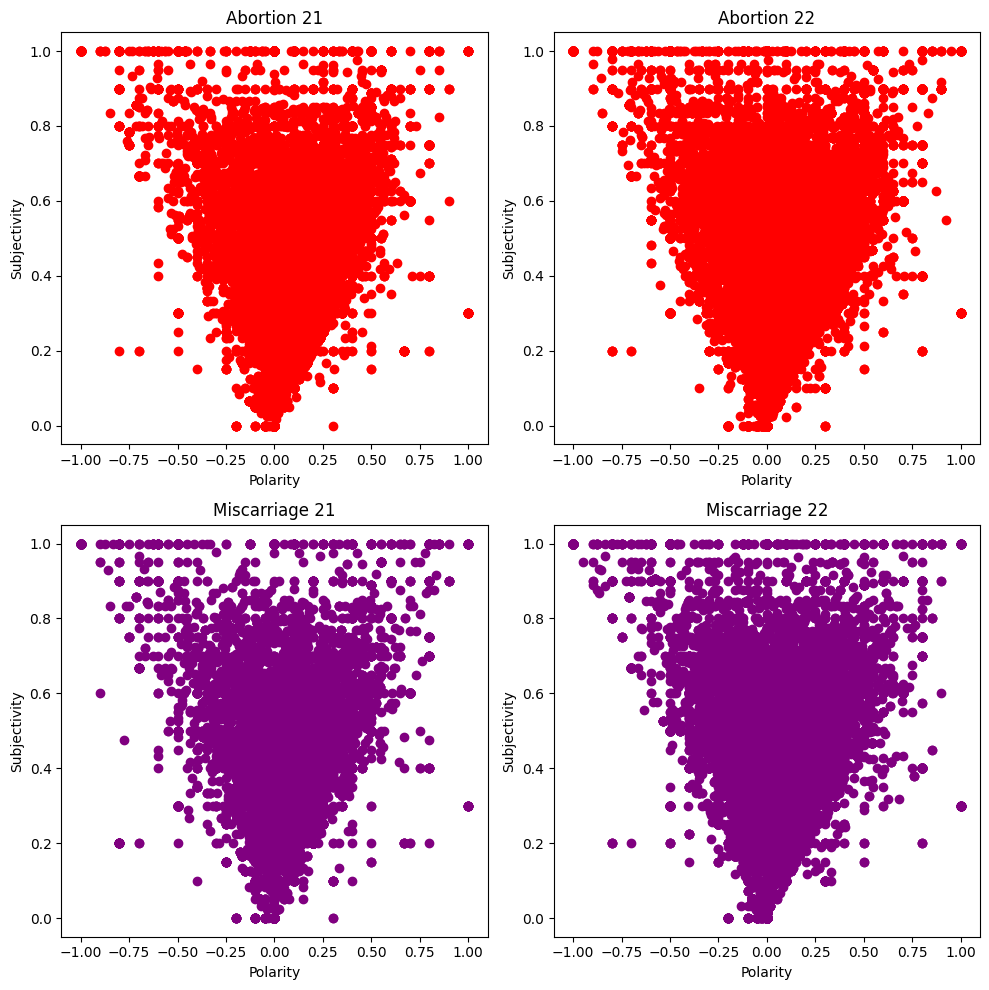

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].scatter(df_abortion21['polarity'], df_abortion21['subjectivity'], color = 'Red')
axs[0,0].set_title('Abortion 21')
axs[0,0].set_xlabel('Polarity')
axs[0,0].set_ylabel('Subjectivity')

axs[0,1].scatter(df_abortion22['polarity'], df_abortion22['subjectivity'], color = 'Red')
axs[0,1].set_title('Abortion 22')
axs[0,1].set_xlabel('Polarity')
axs[0,1].set_ylabel('Subjectivity')

axs[1,0].scatter(df_miscarriage21['polarity'], df_miscarriage21['subjectivity'], color = 'Purple')
axs[1,0].set_title('Miscarriage 21')
axs[1,0].set_xlabel('Polarity')
axs[1,0].set_ylabel('Subjectivity')

axs[1,1].scatter(df_miscarriage22['polarity'], df_miscarriage22['subjectivity'], color = 'Purple')
axs[1,1].set_title('Miscarriage 22')
axs[1,1].set_xlabel('Polarity')
axs[1,1].set_ylabel('Subjectivity')

plt.tight_layout()
plt.show()


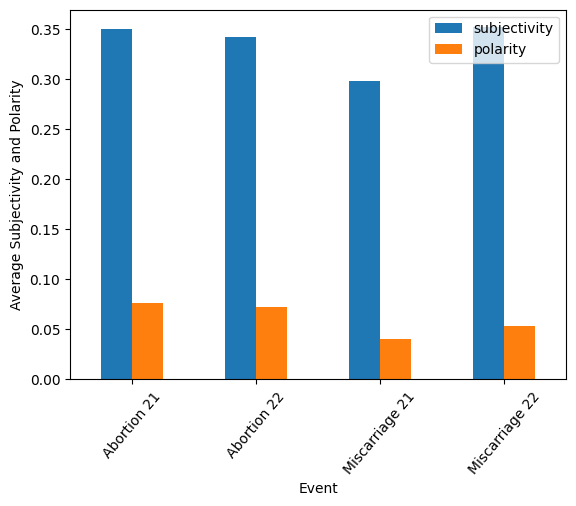

In [44]:
# Group data by event
grouped = df_allsentiment_transformed.groupby('event')

# Calculate average subjectivity and polarity for each group
averages = grouped[['subjectivity', 'polarity']].mean()

averages.plot(kind='bar', y=['subjectivity', 'polarity'], stacked=False)
plt.xlabel('Event')
plt.ylabel('Average Subjectivity and Polarity')
plt.xticks(rotation=50)
plt.show()

In [45]:
#Percentages of positive tweets
positivetwt = df_allsentiment_transformed[df_allsentiment_transformed['analysed'] == 'Positive']
positiveper100 = round( (positivetwt.shape[0]/df_allsentiment_transformed.shape[0])*100, 1)
print('The percentaje of positives is:', positiveper100)

#Percentages of positive tweets
negativetwt = df_allsentiment_transformed[df_allsentiment_transformed['analysed'] == 'Negative']
negativeper100 = round( (negativetwt.shape[0]/df_allsentiment_transformed.shape[0])*100, 1)
print('The percentaje of negatives is:', negativeper100)

#Percentages of neutral tweets
neutraltwt = df_allsentiment_transformed[df_allsentiment_transformed['analysed'] == 'Neutral']
neutralper100 = round( (neutraltwt.shape[0]/df_allsentiment_transformed.shape[0])*100, 1)
print('The percentaje of neutrals is:', neutralper100)

The percentaje of positives is: 45.3
The percentaje of negatives is: 19.9
The percentaje of neutrals is: 34.8


<AxesSubplot: title={'center': 'Sentiment analysis'}, xlabel='Sentiment', ylabel='Counts'>

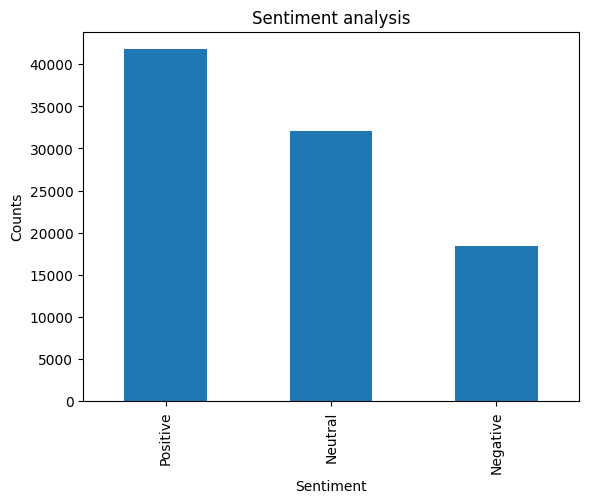

In [46]:
#Visualize the counts ( or percentages)
plt.title('Sentiment analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_allsentiment['analysed'].value_counts().plot(kind = 'bar')

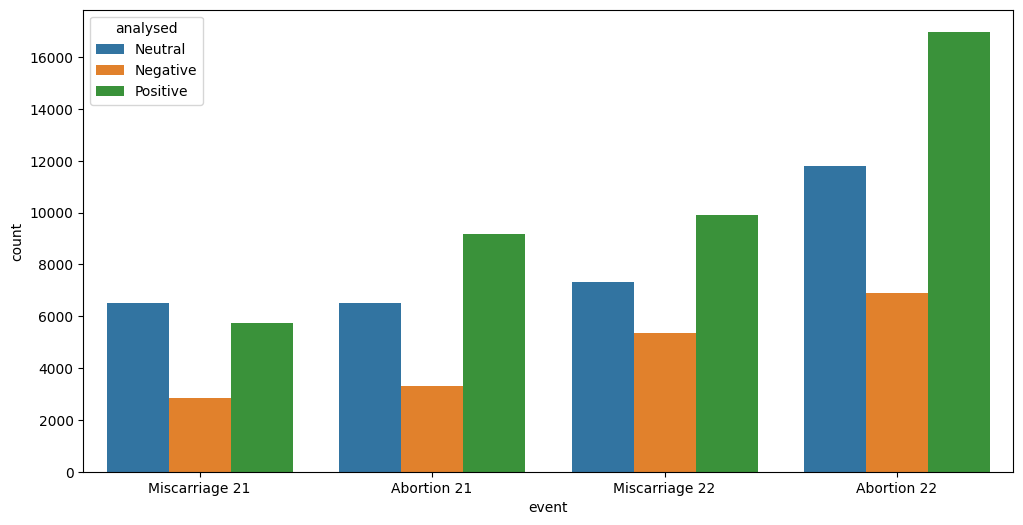

In [47]:
plt.figure(figsize=(12,6))
sns.countplot(x='event', hue='analysed', data= df_allsentiment_transformed)
plt.show()

## Correlation analysis

In [ ]:
#Transform columns of the dataframe to log.scale for the scatter plot and correlation analysis
df_allsentiment_transformed['rt'] = np.log1p(df_allsentiment_transformed['rt'])
df_allsentiment_transformed['likes'] = np.log1p(df_allsentiment_transformed['likes'])
df_allsentiment_transformed['replies'] = np.log1p(df_allsentiment_transformed['replies'])

df_allsentiment_transformed

In [ ]:
# Correlation between public metrics and subjectivity
g = sns.pairplot(df_allsentiment_transformed, vars=('rt', 'replies', 'likes', 'subjectivity'))
g.fig.suptitle("Correlation between public metrics and subjectivity")
plt.show()

In [ ]:
# Correlation between public metrics and subjectivity
g = sns.pairplot(df_allsentiment_transformed, vars=('rt', 'replies', 'likes', 'subjectivity'))
g.fig.suptitle("Correlation between public metrics and subjectivity")
plt.show()

In [ ]:
# Correlation between polarity and subjectivity
s = sns.pairplot(df_allsentiment_transformed, vars=('negative', 'positive', 'neutral', 'subjectivity'))
s.fig.suptitle("Correlation between polarity and subjectivity")
plt.show()

In [ ]:
# Correlation between public metrics and polarity
a = sns.pairplot(df_allsentiment_transformed, vars=('rt', 'replies', 'likes', 'negative', 'positive', 'neutral'))
a.fig.suptitle("Correlation between public metrics and polarity")
plt.show()

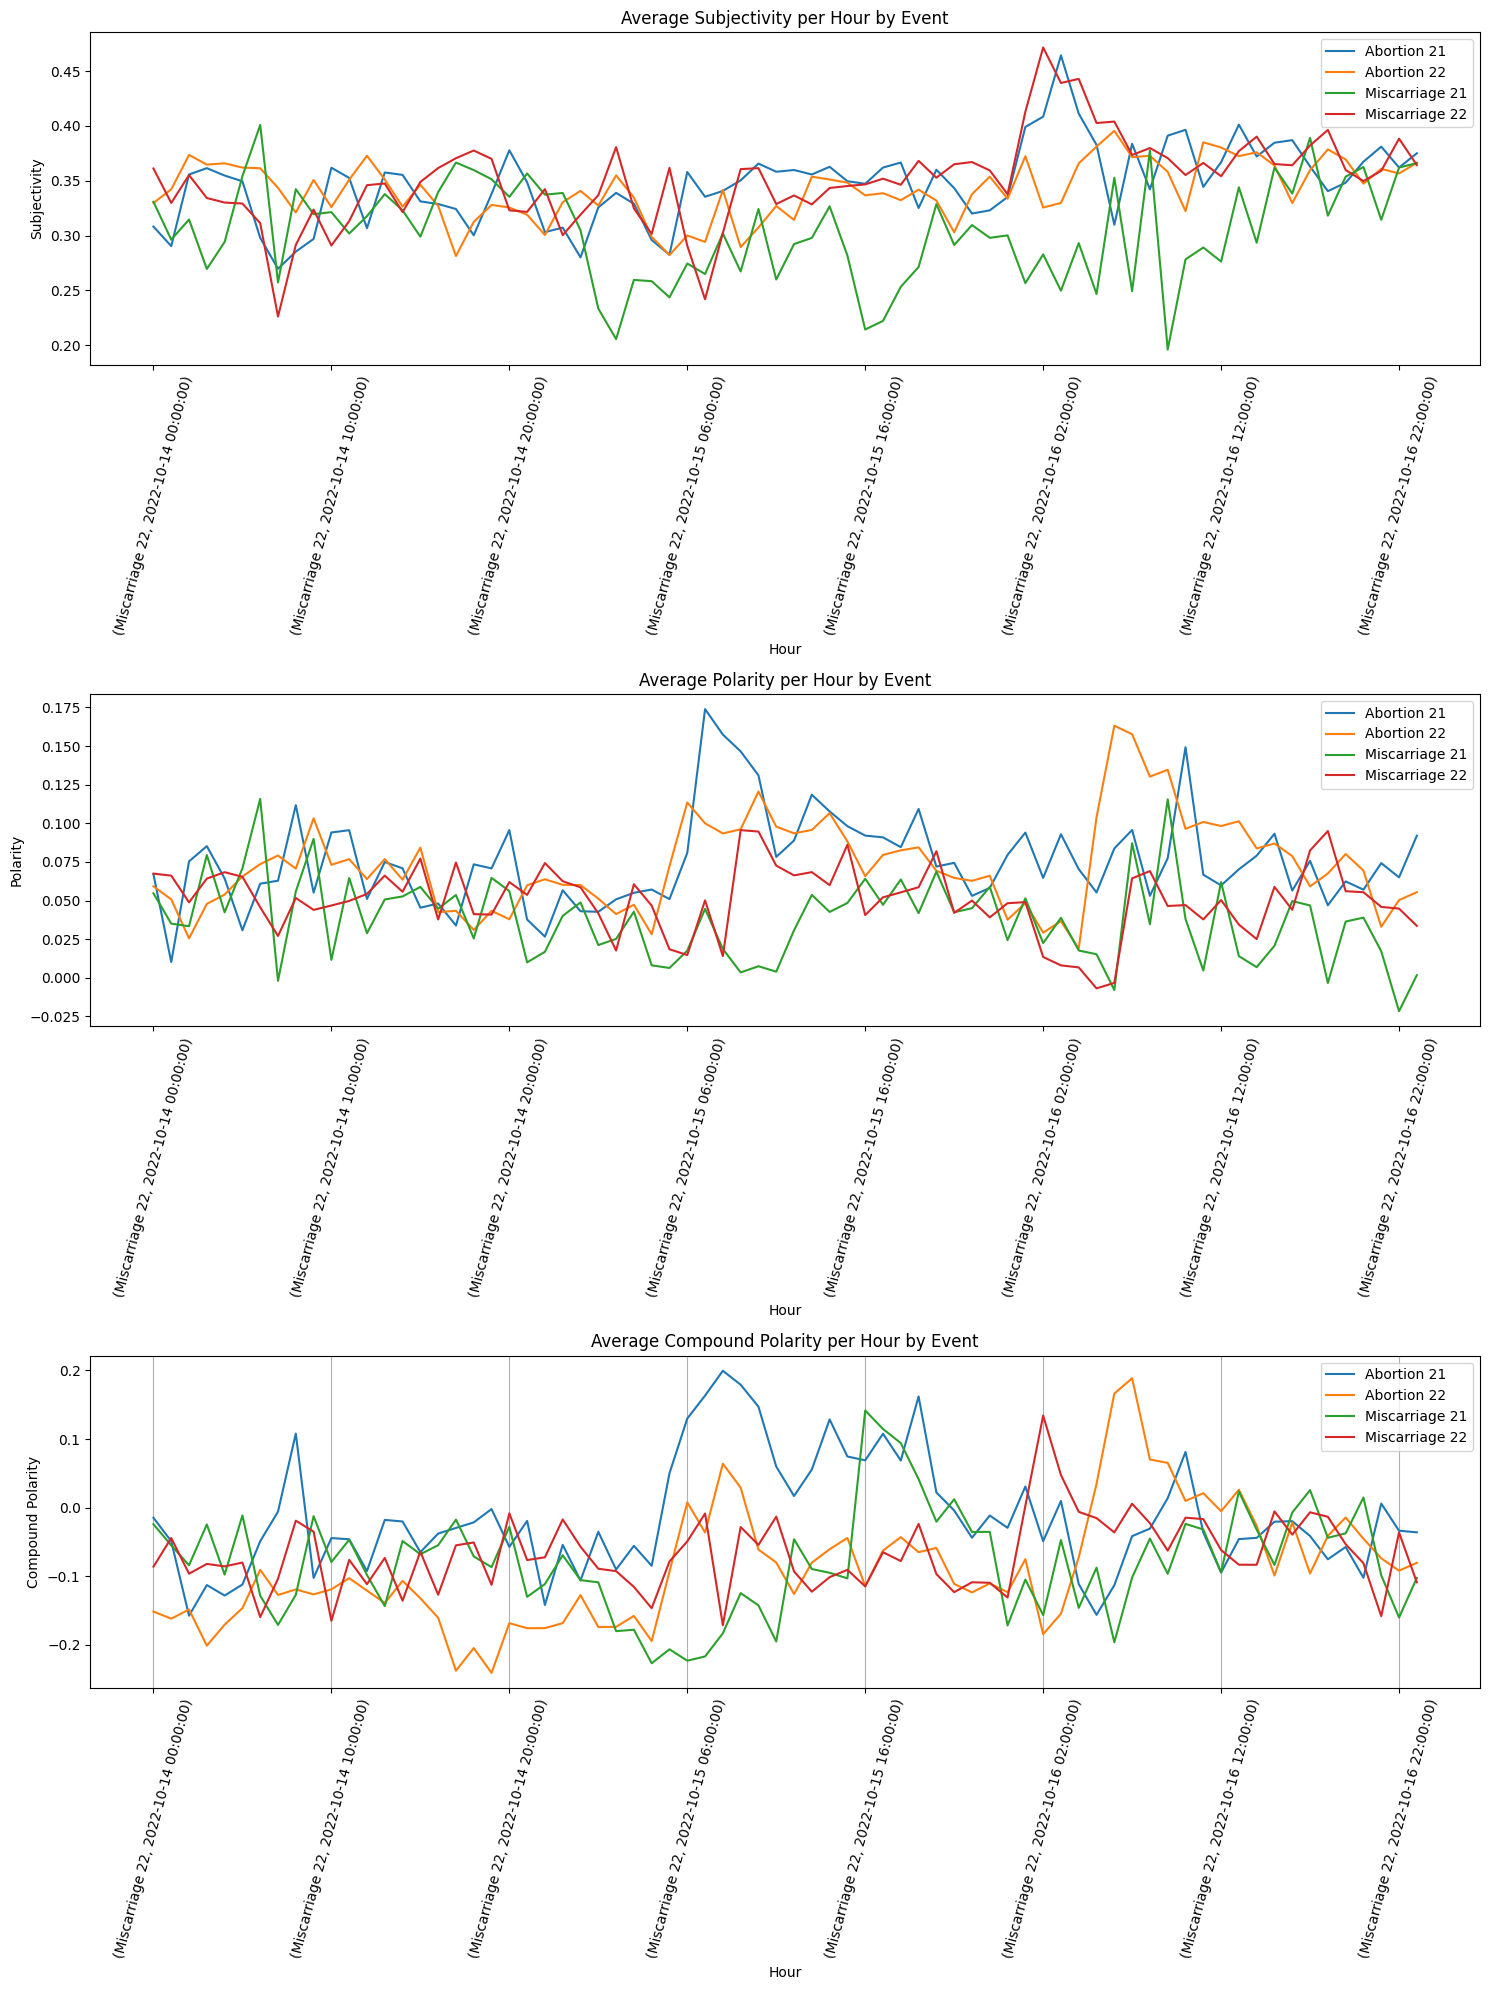

In [119]:
# Group the data by event and hour
grouped = df_allsentiment_transformed.groupby(['event', pd.Grouper(key='created_at', freq='H')])

# resample the data by hour
resampled_subjectivity = grouped['subjectivity'].mean()
resampled_polarity = grouped['polarity'].mean()
resampled_compound = grouped['compound'].mean()

# plot the subjectivity, polarity and compound per hour for each event
fig, axs = plt.subplots(3, 1, figsize=(15, 20))

for event, data in resampled_subjectivity.groupby(level=0):
    data.plot(ax=axs[0], label=event)
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Subjectivity')
axs[0].set_title('Average Subjectivity per Hour by Event')
axs[0].legend()
axs[0].xaxis.set_tick_params(rotation=75)

for event, data in resampled_polarity.groupby(level=0):
    data.plot(ax=axs[1], label=event)
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Polarity')
axs[1].set_title('Average Polarity per Hour by Event')
axs[1].legend()
axs[1].xaxis.set_tick_params(rotation=75)


for event, data in resampled_compound.groupby(level=0):
    data.plot(ax=axs[2], label=event)
axs[2].set_xlabel('Hour')
axs[2].set_ylabel('Compound Polarity')
axs[2].set_title('Average Compound Polarity per Hour by Event')
axs[2].legend()
axs[2].grid(True, axis='x')
axs[2].xaxis.set_tick_params(rotation=75)

plt.tight_layout()
plt.show()

## Topic analysis

In [50]:
# Preparing regex expression with depression words
depression_words = ["overwhelmed", "exhausted", "distressed", "anxiety", "anxious", "tired",
                    "low", "depression", "depressed", "discouraged", "desperate", "demotivated",
                    "insomnia", "cry", "nervous", "worried", "lonely", "sad", "empty"]

depression_words = lemmatize(depression_words)
regex_depr = "|".join(depression_words)

In [51]:
# Filtering tweets with depression words
df_allsentiment_transformed['depression'] = df_allsentiment_transformed['text'].str.contains(regex_depr, regex=True, flags=re.IGNORECASE)
#df['no_depression'] = df[~df['clean_text'].str.contains(regex_depr, regex=True, flags=re.IGNORECASE)]
print("Avg. Depression polarity ", np.mean(df_allsentiment_transformed[df_allsentiment_transformed['depression'] == True]['compound']))
print("Avg. Non depression polarity ", np.mean(df_allsentiment_transformed[df_allsentiment_transformed['depression'] == False]['compound']))


Avg. Depression polarity  -0.12524249730118747
Avg. Non depression polarity  -0.060213319572888085


/tmp/ipykernel_134616/1731819609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsentiment_transformed['depression'] = df_allsentiment_transformed['text'].str.contains(regex_depr, regex=True, flags=re.IGNORECASE)


In [56]:
df_allsentiment_transformed['depression'].value_counts()

False    86722
True      5558
Name: depression, dtype: int64

[Text(0.5, 1.0, 'Compound polarity of tweets in depressed (True) vs. non-depressed (False) users')]

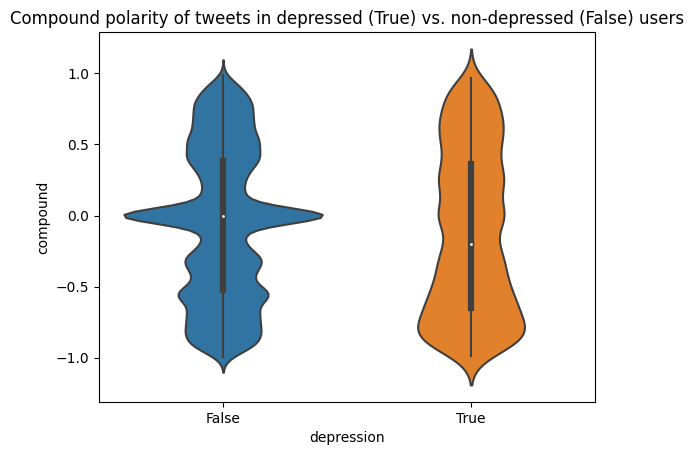

In [116]:
sns.violinplot(data = df_allsentiment_transformed, x = 'depression', y = 'compound').set(title='Compound polarity of tweets in depressed (True) vs. non-depressed (False) users')

In [60]:
#Same with subjectivity
print("Avg. Depression subjectivity ", np.mean(df_allsentiment_transformed[df_allsentiment_transformed['depression'] == True]['subjectivity']))
print("Avg. Non depression subjectivity ", np.mean(df_allsentiment_transformed[df_allsentiment_transformed['depression'] == False]['subjectivity']))

Avg. Depression subjectivity  0.4057038701664242
Avg. Non depression subjectivity  0.33439478474636136


[Text(0.5, 1.0, 'Subjectivity of tweets in depressed (True) vs. non-depressed (False) users')]

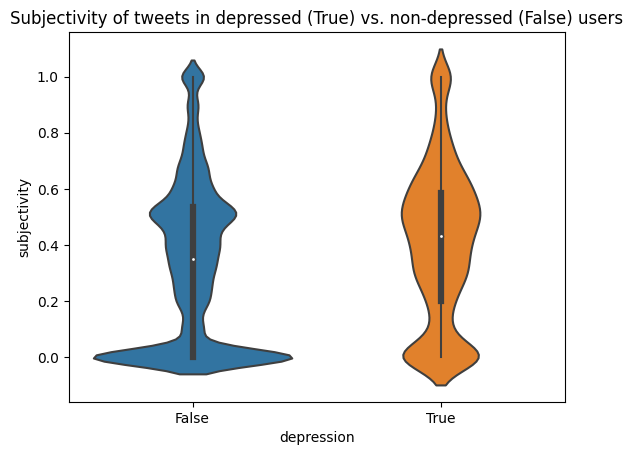

In [117]:
sns.violinplot(data = df_allsentiment_transformed, x = 'depression', y = 'subjectivity').set(title='Subjectivity of tweets in depressed (True) vs. non-depressed (False) users')

#### Correlation analysis
we want to analyse:
- Correlation between the number of tweets and the event
- Correlation between the number of tweets and the year/event
- Mean polarity per event 

In [61]:
from scipy.stats import chisquare
from scipy.stats import chi2_contingency 
from scipy.stats import poisson


In [83]:
# Create the contingency table between the event and year
crosstable_eventnoyear_year = pd.crosstab(df_allsentiment_transformed['year'], df_allsentiment_transformed['event_noyear'],)
print(crosstable_eventnoyear_year)

# Perform the chi-squared test
stat, p1, dof, expected = chi2_contingency(crosstable_eventnoyear_year)

# Print the p-value
print(f'This is the p-value:',p1,'This means that there is a statistically significant difference in the number of tweets done for each event between 2021 and 2022')

event_noyear  Abortion  Miscarriage
year                               
2021             18970        15068
2022             35667        22575
This is the p-value: 1.4061416604051215e-60 This means that there is a statistically significant difference in the number of tweets done for each event between 2021 and 2022


event
Abortion 21      -0.007049
Abortion 22      -0.093236
Miscarriage 21   -0.060317
Miscarriage 22   -0.068655
Name: compound, dtype: float64


Text(0.5, 1.0, 'Perceived polarity of each event')

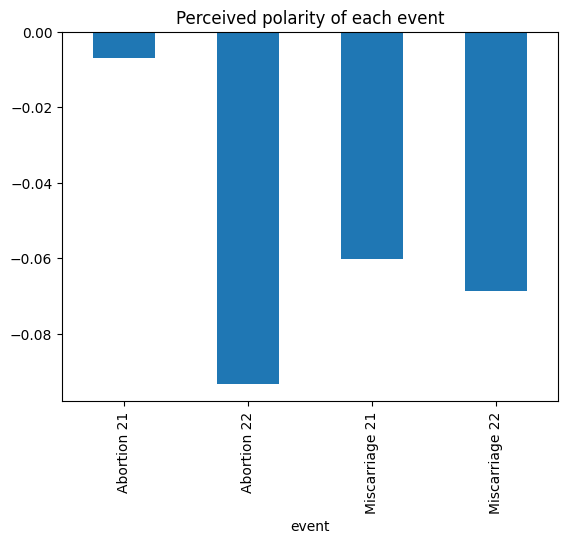

In [129]:
print(df_allsentiment_transformed.groupby("event")["compound"].mean())
df_allsentiment_transformed.groupby("event")["compound"].mean().plot(kind = "bar")
plt.title("Perceived polarity of each event")

event
Abortion 21      -0.054140
Abortion 22      -0.195256
Miscarriage 21   -0.046796
Miscarriage 22   -0.164938
Name: compound, dtype: float64


Text(0.5, 1.0, 'Perceived polarity of tweets per event that presented depression words')

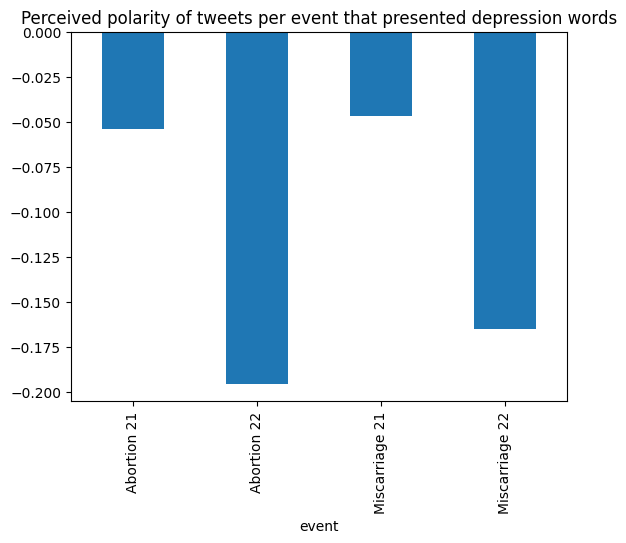

In [132]:
df_depression = df_allsentiment_transformed[df_allsentiment_transformed["depression"]==True]
print(df_depression.groupby("event")["compound"].mean())
df_depression.groupby("event")["compound"].mean().plot(kind = "bar")
plt.title("Perceived polarity of tweets per event that presented depression words")

In [86]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform the two-way ANOVA
model = ols('compound ~ event + year + event:year', data=df_allsentiment_transformed).fit()
aov_table = sm.stats.anova_lm(model, typ=2)

# Print the results
print(aov_table)

                  sum_sq       df             F         PR(>F)
event       1.422618e-09      3.0  1.719363e-09   1.000000e+00
year        3.795884e+02      1.0  1.376301e+03  4.811676e-299
event:year  9.263237e+01      3.0  1.119546e+02   2.322774e-72
Residual    2.545002e+04  92276.0           NaN            NaN


In [124]:
# Create the contingency table between the event and compound mean
crosstable_event_compound = pd.crosstab(df_allsentiment_transformed['event'], df_allsentiment_transformed["depression"])
print(crosstable_event_compound)

# Perform the chi-squared test
stat, p1, dof, expected = chi2_contingency(crosstable_event_compound)

# Print the p-value
print(f'This is the p-value:',p1)

depression      False  True 
event                       
Abortion 21     17599   1371
Abortion 22     33811   1856
Miscarriage 21  14010   1058
Miscarriage 22  21302   1273
This is the p-value: 1.485949441396258e-26


depression    False  True 
event_noyear              
Abortion      51410   3227
Miscarriage   35312   2331
This is the p-value: 0.0748454692710539


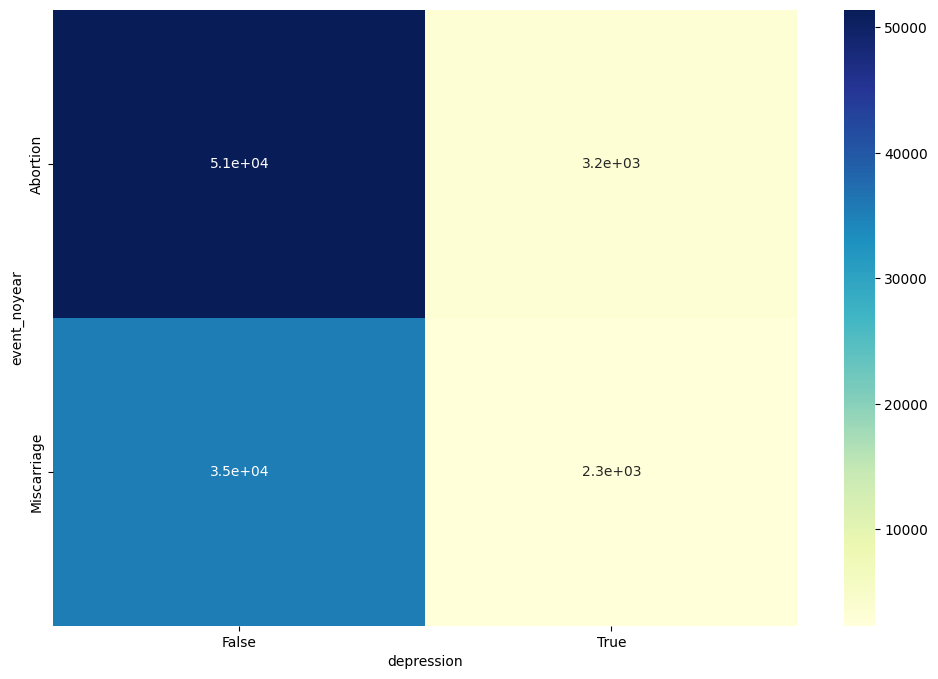

In [87]:
# Create the contingency table between the event and depression
crosstable_eventnoyear_depression = pd.crosstab(df_allsentiment_transformed['event_noyear'], df_allsentiment_transformed['depression'])
print(crosstable_eventnoyear_depression)

plt.figure(figsize=(12,8))
sns.heatmap(crosstable_eventnoyear_depression, annot=True, cmap="YlGnBu")


# Perform the chi-squared test
stat, p2, dof, expected = chi2_contingency(crosstable_eventnoyear_depression)

# Print the p-value
print(f'This is the p-value:',p2)

year           2021   2022
event_noyear              
Abortion      18970  35667
Miscarriage   15068  22575
This is the p-value: 1.4061416604051215e-60


[Text(0.5, 1.0, 'Depression per event per year')]

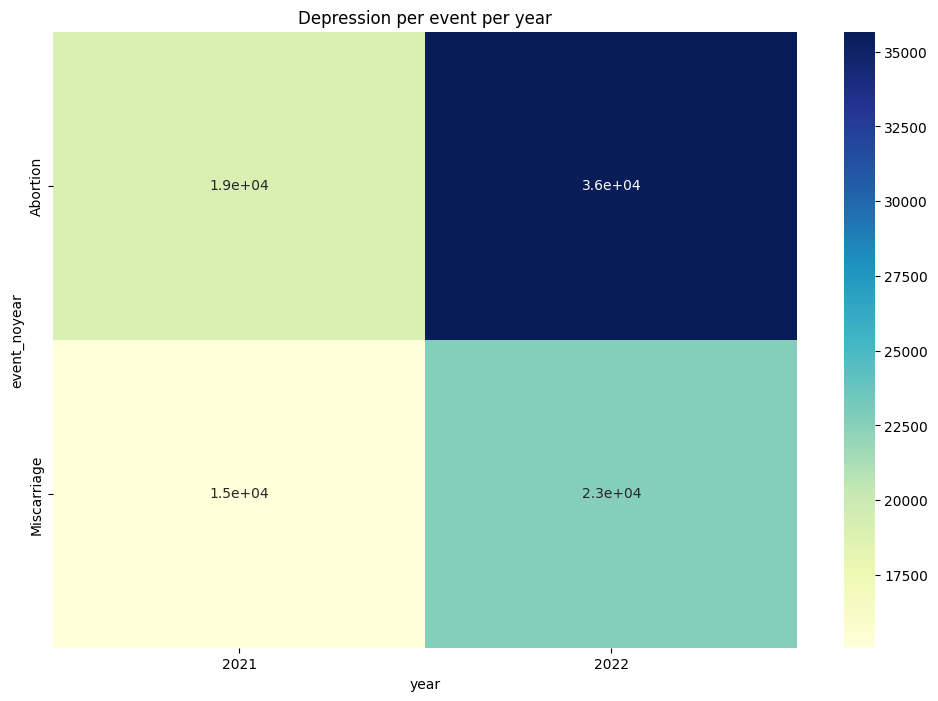

In [145]:
crosstable_event_depression_year = pd.crosstab(
    index=df_allsentiment_transformed['event_noyear'],
    columns=df_allsentiment_transformed['year'],
    values=df_allsentiment_transformed['depression'],
    aggfunc='count'
)

print(crosstable_event_depression_year)

# Perform the chi-squared test
stat, p3, dof, expected = chi2_contingency(crosstable_event_depression_year)

# Print the p-value
print(f'This is the p-value:',p3)

plt.figure(figsize=(12,8))
sns.heatmap(crosstable_event_depression_year, annot=True, cmap="YlGnBu").set(title='Depression per event per year')

depression      False  True 
event                       
Abortion 21     17599   1371
Abortion 22     33811   1856
Miscarriage 21  14010   1058
Miscarriage 22  21302   1273
This is the p-value: 1.485949441396258e-26


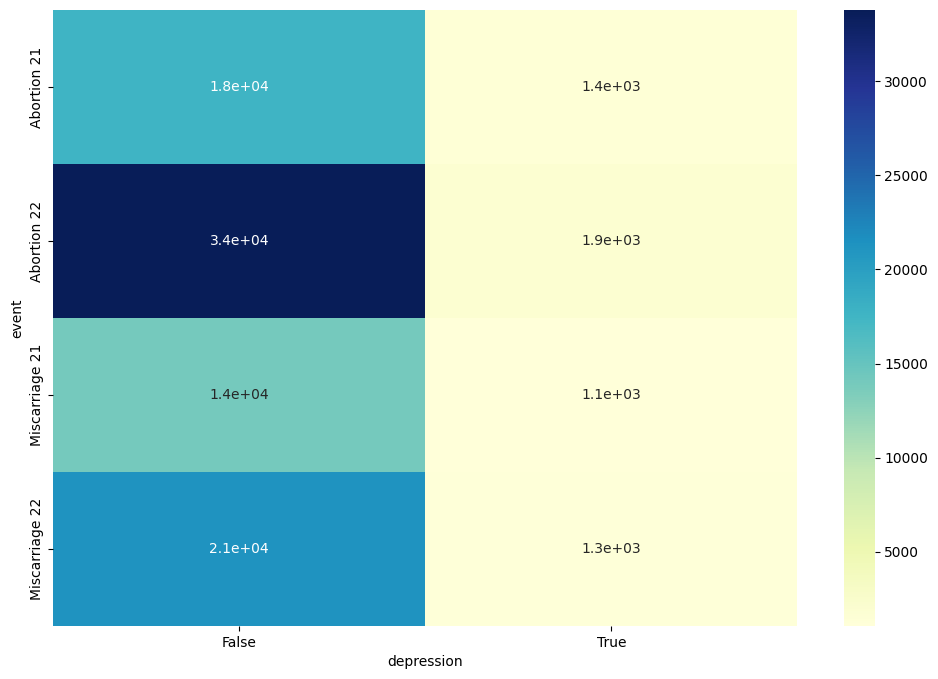

In [88]:
# Create the contingency table between the event and year
crosstable_event_depression = pd.crosstab(df_allsentiment_transformed['event'], df_allsentiment_transformed['depression'])
print(crosstable_event_depression)

plt.figure(figsize=(12,8))
sns.heatmap(crosstable_event_depression, annot=True, cmap="YlGnBu")

# Perform the chi-squared test
stat, p4, dof, expected = chi2_contingency(crosstable_event_depression)

# Print the p-value
print(f'This is the p-value:',p4)

In [125]:
from scipy.stats import pearsonr

# Create the contingency table between the event and depression
crosstable_event_depression = pd.crosstab(df_allsentiment_transformed['event'], df_allsentiment_transformed['depression'])

# Calculate the Pearson's correlation coefficient and p-value
corr, p_value = pearsonr(crosstable_event_depression[True], crosstable_event_depression[False])

print("Pearson's correlation coefficient:", corr)
print("p-value:", p_value)

Pearson's correlation coefficient: 0.9540981557745954
p-value: 0.04590184422540455


In [104]:
event_depression_perc = df_allsentiment_transformed.groupby('event')['depression'].mean() * 100
print(event_depression_perc)

event
Abortion 21       7.227201
Abortion 22       5.203690
Miscarriage 21    7.021503
Miscarriage 22    5.638981
Name: depression, dtype: float64


In [121]:
event_noyear_depression_perc = df_allsentiment_transformed.groupby('event_noyear')['depression'].mean() * 100
print(event_noyear_depression_perc)

event_noyear
Abortion       5.906254
Miscarriage    6.192386
Name: depression, dtype: float64


In [114]:
events = df_allsentiment_transformed["event"].unique()

for event in events:
    percentage = (len(df_allsentiment_transformed[(df_allsentiment_transformed['event'] == event) & (df_allsentiment_transformed["depression"] == True)]) / len(df_allsentiment_transformed[df_allsentiment_transformed['event'] == event]))*100
    print(f"Percentage of tweets during {event} that included depression words: {percentage:.2f}%")


Percentage of tweets during Miscarriage 21 that included depression words: 7.02%
Percentage of tweets during Abortion 21 that included depression words: 7.23%
Percentage of tweets during Miscarriage 22 that included depression words: 5.64%
Percentage of tweets during Abortion 22 that included depression words: 5.20%


In [122]:
events = df_allsentiment_transformed["event_noyear"].unique()

for event in events:
    percentage = (len(df_allsentiment_transformed[(df_allsentiment_transformed['event_noyear'] == event) & (df_allsentiment_transformed["depression"] == True)]) / len(df_allsentiment_transformed[df_allsentiment_transformed['event_noyear'] == event]))*100
    print(f"Percentage of tweets during {event} that included depression words: {percentage:.2f}%")


Percentage of tweets during Miscarriage that included depression words: 6.19%
Percentage of tweets during Abortion that included depression words: 5.91%


In [ ]:
government_authors = ['SethMagaziner', 'SenatorShaheen', 'SenatorDurbin', 'SenatorBaldwin', 'SenWhitehouse', 'SenWarren', 'SenCortezMasto', 'SenBlumenthal',
 'ReverendWarnock', 'RepSaraJacobs', 'RepRussFulcher', 'RepMikeQuigley', 'RepMGS', 'RepJimmyGomez', 'RepGwenMoore', 'RepDeborahRoss',
 'RepDLesko', 'RepCasten', 'RepBethVanDuyne', 'RepAOC', 'repdinatitus', 'timkaine', 'gillibrandny', 'francediplo_EN', 'FrankPallone',    'CaptMarkKelly',
 'BillPascrell', 'HouseJudiciary', 'JacksonLeeTX18', 'RepBillFoster', 'RepDonBeyer', 'RepEscobar', 'JohnFetterman',    'SpeakerPelosi', 'WHO', 
 'CongressmanRaja', 'janschakowsky', 'JudiciaryDems', 'Rep_Stansbury', 'RepSylviaGarcia', 'RepDianaDeGette',    'RepLoriTrahan', 'RepJudyChu', 
 'maziehirono', 'OversightDems', 'RepJayapal', 'PattyMurray']

In [141]:
government = df_allsentiment_transformed[df_allsentiment_transformed['author'].isin(government_authors)]

[Text(0.5, 1.0, 'Compound polarity of tweets in depressed (True) vs. non-depressed (False) users')]

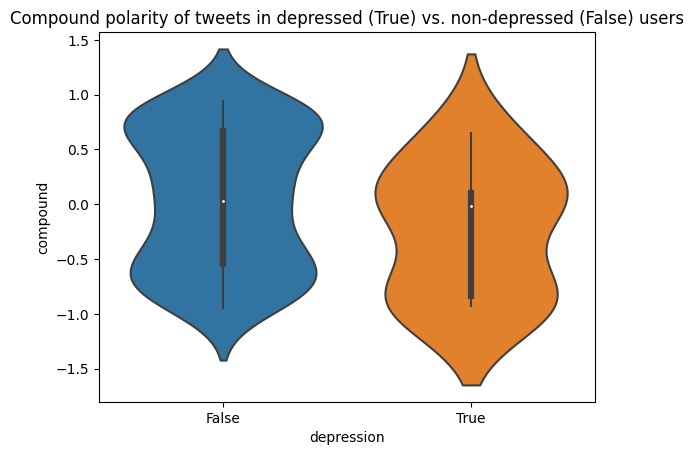

In [142]:
sns.violinplot(data = government, x = 'depression', y = 'compound').set(title='Compound polarity of tweets in depressed (True) vs. non-depressed (False) users')